# Droplet Evaporation Analysis

This application analyzes time-lapse images of sessile droplets to quantify changes in droplet geometry and volume during evaporation. The workflow combines automated image processing with optional user-guided baseline selection to ensure robust and reproducible measurements across different surfaces.

**Stage 1 – SETUP: Initialize the Analysis Environment**

**Purpose**:

This stage prepares the computational environment required for the droplet evaporation analysis.

**What happens**:

Required Python libraries for image processing and data analysis are installed

Google Drive is mounted

The base directory containing the experiment images is defined

The auxiliary functions file (finding_base.py) is loaded

**User action:**

Run this cell once at the beginning of the workflow.
If an error occurs, verify that the directory structure is correct and that finding_base.py is located in the base folde

In [ ]:

# setup
#@title 1. run me first


# ======================================
# SETUP CELL – run this first
# ======================================

# ---- Install required libraries ----
!pip install -q streamlit opencv-python-headless scikit-image matplotlib pandas

# ---- Imports ----
import os
import sys
from pathlib import Path

from google.colab import drive

# ---- Mount Google Drive ----
drive.mount('/content/drive')

# ---- Define base directory ----
base_image_dir = "/content/drive/MyDrive/פרוייקט עיבוד תמונה"

print("Base image directory:")
print(base_image_dir)

# ---- Verify base directory exists ----
if not os.path.exists(base_image_dir):
    raise FileNotFoundError(
        f"Base directory not found: {base_image_dir}\n"
        "Check the folder name and location in Google Drive."
    )

print("✅ Base directory found")

# ---- Add base directory to PYTHONPATH ----
# This allows importing finding_base.py from there
sys.path.append(base_image_dir)

# ---- Verify finding_base.py ----
try:
    import finding_base
    print("✅ finding_base.py imported successfully")
except ImportError as e:
    raise ImportError(
        "❌ finding_base.py was not found in base_image_dir.\n"
        "Make sure it is located directly inside:\n"
        f"{base_image_dir}"
    ) from e

print("✅ SETUP completed successfully")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.4 MB/s eta 0:00:00
Mounted at /content/drive
Base image directory:
/content/drive/MyDrive/פרוייקט עיבוד תמונה
✅ Base directory found
✅ finding_base.py imported successfully
✅ SETUP completed successfully


**Stage 2 – Select Treatment and Create every_10_frames**

**Purpose:**

Reduce the number of images analyzed in order to significantly improve runtime efficiency without losing essential temporal information.

**What happens:**

A treatment folder is selected

For each replicate, every 10th image (frameXXXX.png) is selected

Selected images are copied into a new subfolder named every_10_frames

Why this is needed:

Images are acquired every 0.9 seconds. Analyzing all frames is computationally expensive and unnecessary.
Subsampling preserves the evaporation trend while reducing processing time.



**User note:
This is a time-consuming step and should be executed only once per experiment.**

In [ ]:
# ======================================
#@title 2. Select treatment type and create every_10_frames for each sub-folder
# ======================================

import os
import re
import shutil
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

# --------------------------------------------------
# Base directory (from setup cell)
# --------------------------------------------------
base_path = Path(base_image_dir)

# --------------------------------------------------
# List treatment folders
# --------------------------------------------------
treatment_folders = [
    f.name for f in base_path.iterdir()
    if f.is_dir()
]

if not treatment_folders:
    raise RuntimeError("❌ No treatment folders found in base_image_dir")

folder_dropdown = widgets.Dropdown(
    options=treatment_folders,
    description="Treatment:",
    layout=widgets.Layout(width="60%")
)

run_button = widgets.Button(
    description="Create every_10_frames for all subfolders",
    button_style="success"
)

output_area = widgets.Output()

display(folder_dropdown, run_button, output_area)

# --------------------------------------------------
# Button callback
# --------------------------------------------------
treatment_dir = None

def on_run_clicked(b):
    global treatment_dir
    with output_area:
        clear_output()

        selected_folder = folder_dropdown.value
        treatment_dir = base_path / selected_folder

        print("Selected treatment folder:")
        print(treatment_dir)

        # ------------------------------------------
        # Find subfolders (runs / repeats / samples)
        # ------------------------------------------
        sub_dirs = [
            d for d in treatment_dir.iterdir()
            if d.is_dir()
        ]

        if not sub_dirs:
            print("❌ No subfolders found inside treatment folder")
            return

        print(f"Found {len(sub_dirs)} subfolders")

        # ------------------------------------------
        # Process each subfolder
        # ------------------------------------------
        for sub_dir in sub_dirs:
            print(f"\n▶ Processing: {sub_dir.name}")

            try:
                # ----------------------------------
                # Find frameXXXX.png images
                # ----------------------------------
                image_files = [
                    f for f in os.listdir(sub_dir)
                    if re.match(r"frame\d{4}\.png", f)
                ]

                if not image_files:
                    print("  ⚠️ No frameXXXX.png images found – skipping")
                    continue

                image_files.sort(
                    key=lambda f: int(re.search(r"\d{4}", f).group())
                )

                # ----------------------------------
                # Select every 10th frame
                # ----------------------------------
                selected_images = [
                    f for f in image_files
                    if int(re.search(r"\d{4}", f).group()) % 10 == 0
                ]

                print(f"  Found {len(selected_images)} selected images")

                if not selected_images:
                    print("  ⚠️ No images matched every-10 condition – skipping")
                    continue

                # ----------------------------------
                # Create output directory
                # ----------------------------------
                output_dir = sub_dir / "every_10_frames"
                output_dir.mkdir(exist_ok=True)

                # ----------------------------------
                # Copy files
                # ----------------------------------
                for fname in selected_images:
                    try:
                        src = sub_dir / fname
                        dst = output_dir / fname
                        shutil.copy2(src, dst)
                    except Exception as e:
                        print(f"    ❌ Failed copying {fname}: {e}")

                print(f"  ✅ Done: {output_dir}")

            except Exception as e:
                print(f"  ❌ Error while processing {sub_dir.name}: {e}")

        print("\n✅ Stage 2 completed for all subfolders")

run_button.on_click(on_run_clicked)


Dropdown(description='Treatment:', layout=Layout(width='60%'), options=('__pycache__', 'tap on parafim ', 'dec…

Button(button_style='success', description='Create every_10_frames for all subfolders', style=ButtonStyle())

Output()

**Stage 3 – Calibration: Compute mm-per-pixel**

**Purpose:**

Convert pixel-based measurements into physical units (millimeters) using the known diameter of the pipette tip.

**What happens:**

For each replicate, frame0000.png is analyzed

The pipette tip width is detected automatically

A conversion factor (mm/px) is computed

Calibration values are saved per replicate

**Why this is critical:**

All geometric quantities (height, base width, volume) depend directly on accurate spatial calibration.

In [ ]:
# ======================================
#@title 3. Compute mm_per_pixel from existing every_10_frames folders
# ======================================

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path

# --------------------------------------------------
# Safety check
# --------------------------------------------------
if "base_image_dir" not in globals():
    raise RuntimeError("❌ base_image_dir not defined. Run SETUP first.")

# finding_base אמור להיות מיובא כבר ב־SETUP
if "finding_base" not in globals():
    raise RuntimeError("❌ finding_base not imported. Run SETUP first.")

base_path = Path(base_image_dir)

# --------------------------------------------------
# Select treatment folder
# --------------------------------------------------
treatment_folders = [
    f.name for f in base_path.iterdir()
    if f.is_dir()
]

treatment_dropdown = widgets.Dropdown(
    options=treatment_folders,
    description="Treatment:",
    layout=widgets.Layout(width="60%")
)

run_button = widgets.Button(
    description="Compute mm_per_pixel",
    button_style="success"
)

output_area = widgets.Output()

display(treatment_dropdown, run_button, output_area)

# --------------------------------------------------
# Button callback
# --------------------------------------------------
def on_run_clicked(b):
    with output_area:
        clear_output()

        treatment_dir = base_path / treatment_dropdown.value
        print("Selected treatment:")
        print(treatment_dir)

        # ------------------------------------------
        # Find runs with every_10_frames
        # ------------------------------------------
        run_dirs = [
            d for d in treatment_dir.iterdir()
            if d.is_dir() and (d / "every_10_frames").exists()
        ]

        if not run_dirs:
            print("❌ No every_10_frames folders found.")
            return

        print(f"Found {len(run_dirs)} runs with every_10_frames")

        rows = []

        for run_dir in run_dirs:
            print(f"\n▶ Calibrating: {run_dir.name}")

            every_10_dir = run_dir / "every_10_frames"
            img_path = every_10_dir / "frame0000.png"

            if not img_path.exists():
                print("  ❌ frame0000.png not found – skipping")
                continue

            try:
                # 🔴 THIS IS THE IMPORTANT FIX
                mm_val = finding_base.compute_mm_per_pixel(
                    str(img_path),
                    plot=True
                )

                rows.append({
                    "treatment": treatment_dir.name,
                    "run_id": run_dir.name,
                    "mm_per_pixel": mm_val
                })

                print(f"  ✅ mm_per_pixel = {mm_val}")

            except Exception as e:
                print(f"  ❌ Calibration failed: {e}")

        if not rows:
            print("\n❌ No successful calibrations.")
            return

        df = pd.DataFrame(rows)

        out_dir = treatment_dir / "aggregated"
        out_dir.mkdir(exist_ok=True)

        csv_path = out_dir / "mm_per_pixel_per_run.csv"
        df.to_csv(csv_path, index=False)

        print("\n✅ Calibration summary saved to:")
        print(csv_path)

        display(df)

run_button.on_click(on_run_clicked)


Dropdown(description='Treatment:', layout=Layout(width='60%'), options=('__pycache__', 'tap on parafim ', 'dec…

Button(button_style='success', description='Compute mm_per_pixel', style=ButtonStyle())

Output()

**Stage 3.5 – Interactive Baseline Selection (Per Replicate)**

**Purpose:**

Allow manual selection of the droplet baseline to improve robustness across different surfaces and imaging conditions.

**What happens:**

For each replicate, two baseline options are displayed:

Droplet-based baseline – automatically detected from droplet geometry

Surface-based baseline – detected from the surface gradient in the image

Both baselines are overlaid on the same image, allowing direct comparison.

**Why this matters:**

On reflective or textured surfaces, automatic detection may fail or shift.
Manual selection ensures consistent and physically meaningful baseline positioning.

**User action:
Select the preferred baseline method and click “Confirm & next”.
Replicates may be skipped if necessary.**

In [ ]:
# ======================================
#@title 3.5 Interactive baseline selection (per replicate, sequential UI)
# ======================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# --------------------------------------------------
# Safety checks
# --------------------------------------------------
# --------------------------------------------------
# Resolve treatment_dir (same logic as Stage 4)
# --------------------------------------------------
if "base_image_dir" not in globals():
    raise RuntimeError("❌ base_image_dir not defined. Run SETUP first.")

if "treatment_dropdown" not in globals():
    raise RuntimeError("❌ treatment_dropdown not found. Run Stage 3 first.")

treatment_name = treatment_dropdown.value
treatment_dir = Path(base_image_dir) / treatment_name

print("STAGE 3.5 – Processing treatment:")
print(treatment_dir)


if "finding_base" not in globals():
    raise RuntimeError("❌ finding_base not imported. Run SETUP first.")

# Ensure the functions exist on the module
required = [
    "load_and_crop_image",
    "blur_and_clahe",
    "otsu_standard",
    "refine_image_by_filling",
    "find_droplet_window",
]
for name in required:
    if not hasattr(finding_base, name):
        raise RuntimeError(f"❌ finding_base.{name} not found. Check finding_base.py")

# --------------------------------------------------
# Global storage for user choices (created fresh here)
# --------------------------------------------------
baseline_selection = {}

# --------------------------------------------------
# Local surface-based baseline function (uses finding_base.load_and_crop_image)
# --------------------------------------------------
def find_surface_line(image_path, debug=False):
    # Small ROI near the top where the surface line is expected
    raw, _ = finding_base.load_and_crop_image(str(image_path), [400, 720, 0, 100])

    raw_blur = cv2.GaussianBlur(raw, (5, 5), 0)

    grad_y = cv2.Sobel(raw_blur, cv2.CV_64F, dx=0, dy=1, ksize=3)
    grad_y = np.abs(grad_y)

    y_candidates = [int(np.argmax(grad_y[:, x])) for x in range(grad_y.shape[1])]
    y_baseline = int(np.median(y_candidates))

    if debug:
        plt.figure(figsize=(6, 4))
        plt.imshow(raw, cmap="gray")
        plt.axhline(y_baseline, color="red")
        plt.title("Detected surface baseline (ROI)")
        plt.axis("off")
        plt.show()

    return y_baseline

# --------------------------------------------------
# Find replicate folders that contain every_10_frames/frame0000.png
# --------------------------------------------------
treatment_path = Path(treatment_dir)

run_dirs = sorted([
    d for d in treatment_path.iterdir()
    if d.is_dir() and (d / "every_10_frames" / "frame0000.png").exists()
])

if not run_dirs:
    raise RuntimeError("❌ No replicate folders with every_10_frames/frame0000.png found.")

print(f"STAGE 3.5 – Found {len(run_dirs)} replicates")

# --------------------------------------------------
# UI elements (persistent)
# --------------------------------------------------
out = widgets.Output()

radio = widgets.RadioButtons(
    options=[
        ("Use droplet-based baseline (find_droplet_window)", "droplet"),
        ("Use surface-based baseline (find_surface_line)", "surface")
    ],
    description="Choose:",
    layout={"width": "max-content"}
)

confirm_btn = widgets.Button(description="Confirm & next", button_style="success")
skip_btn = widgets.Button(description="Skip replicate", button_style="warning")

ui = widgets.HBox([confirm_btn, skip_btn])

display(out, radio, ui)

# --------------------------------------------------
# State
# --------------------------------------------------
state = {"i": 0, "cache": {}}

def show_replicate(i):
    """Compute + plot for replicate i, and cache y_b1/y_b2 for selection."""
    with out:
        clear_output(wait=True)

        run_dir = run_dirs[i]
        run_name = run_dir.name
        frame0 = run_dir / "every_10_frames" / "frame0000.png"

        print(f"▶ Replicate {i+1}/{len(run_dirs)}: {run_name}")
        print(f"   Image: {frame0}")

        # --- Load and crop droplet ROI (same ROI you used) ---
        raw, _ = finding_base.load_and_crop_image(str(frame0), [400, 720, 200, 1100])

        # --- Build mask ---
        processed = finding_base.blur_and_clahe(raw)
        binary_mask = finding_base.refine_image_by_filling(
            finding_base.otsu_standard(processed)
        )

        # --- Droplet-based baseline + contacts ---
        y_b1, x_left, x_right = finding_base.find_droplet_window(binary_mask)

        # --- Surface-based baseline (computed on separate ROI near top) ---
        y_b2 = find_surface_line(frame0, debug=False)

        # Cache
        state["cache"] = {
            "run_name": run_name,
            "y_b1": y_b1,
            "y_b2": y_b2,
            "x_left": x_left,
            "x_right": x_right,
        }

        # --- Plot ---
        plt.figure(figsize=(10, 5))
        plt.imshow(raw, cmap="gray")

        plt.axhline(y_b1, color="red", linestyle="--",
                    label=f"Droplet baseline y={y_b1}")
        plt.axhline(y_b2, color="blue", linestyle="--",
                    label=f"Surface baseline y={y_b2}")


        plt.title(
            f"{run_name}\n"
            f"Droplet y={y_b1} | Surface y={y_b2}"
        )
        plt.legend()
        plt.axis("off")
        plt.tight_layout()
        plt.show()

def advance():
    state["i"] += 1
    if state["i"] >= len(run_dirs):
        with out:
            clear_output(wait=True)
            print("✅ STAGE 3.5 completed.\n")
            print("Selected baselines:")
            for k, v in baseline_selection.items():
                print(f"  {k}: {v}")
        confirm_btn.disabled = True
        skip_btn.disabled = True
        radio.disabled = True
    else:
        show_replicate(state["i"])

def on_confirm_clicked(b):
    global baseline_selection
    c = state["cache"]
    run_name = c["run_name"]
    method = radio.value

    y_selected = c["y_b1"] if method == "droplet" else c["y_b2"]

    baseline_selection[run_name] = {
        "method": method,
        "y_baseline_px": int(y_selected),
        "y_droplet_px": int(c["y_b1"]) if c["y_b1"] is not None else None,
        "y_surface_px": int(c["y_b2"]) if c["y_b2"] is not None else None,
        "x_left": int(c["x_left"]) if c["x_left"] is not None else None,
        "x_right": int(c["x_right"]) if c["x_right"] is not None else None,
    }

    advance()

def on_skip_clicked(b):
    # Just move on without saving this replicate
    advance()

confirm_btn.on_click(on_confirm_clicked)
skip_btn.on_click(on_skip_clicked)

# Start with first replicate
show_replicate(state["i"])


STAGE 3.5 – Processing treatment:
/content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass
STAGE 3.5 – Found 3 replicates


Output()

RadioButtons(description='Choose:', layout=Layout(width='max-content'), options=(('Use droplet-based baseline …

**Stage 4 – Build DataFrame per Replicate**

**Purpose:**

Extract geometric droplet parameters over time and organize them into structured tables.

**What happens:**

Each image is pre-processed and segmented

Droplet height and base width are calculated

Time information is assigned to each frame

The baseline selected in Stage 3.5 is applied (if available)

A DataFrame is created for each replicate

**Output:**

One DataFrame per replicate, ready for further analysis.

Processing treatment:
/content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass
Loaded mm_per_pixel for runs:
  16.7.24 decyl on glass: 0.0043715846994535
  11.7.24 decyl on glass: 0.0043478260869565
  11.7.24 decyl on glass3: 0.0043478260869565

Found 3 replicate folders

▶ Processing replicate: 16.7.24 decyl on glass
  Using mm_per_pixel = 0.0043715846994535
  Found 154 images
  Using baseline from Stage 3.5: droplet, y=291


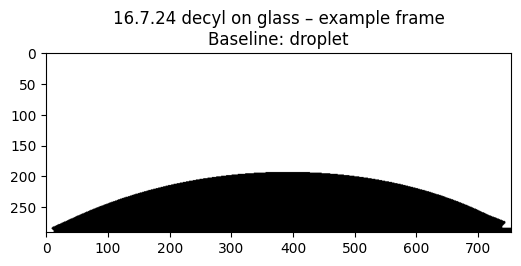

  ✅ DataFrame created: (154, 5)

▶ Processing replicate: 11.7.24 decyl on glass
  Using mm_per_pixel = 0.0043478260869565
  Found 158 images
  Using baseline from Stage 3.5: droplet, y=229


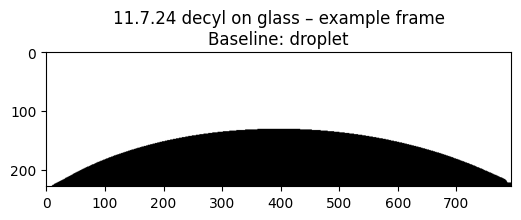

  ✅ DataFrame created: (158, 5)

▶ Processing replicate: 11.7.24 decyl on glass3
  Using mm_per_pixel = 0.0043478260869565
  Found 171 images
  Using baseline from Stage 3.5: droplet, y=247
  ✅ DataFrame created: (92, 5)

✅ STAGE 4 completed
DataFrames created for runs:
 - 16.7.24 decyl on glass
 - 11.7.24 decyl on glass
 - 11.7.24 decyl on glass3


In [ ]:
# ======================================
#@title 4. Build DataFrame per replicate
# ======================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------
# Safety checks
# --------------------------------------------------
if "base_image_dir" not in globals():
    raise RuntimeError("❌ base_image_dir not defined. Run SETUP first.")

if "finding_base" not in globals():
    raise RuntimeError("❌ finding_base not imported. Run SETUP first.")

base_path = Path(base_image_dir)

# --------------------------------------------------
# Select treatment
# --------------------------------------------------
treatment_name = treatment_dropdown.value  # reuse dropdown from Stage 3
treatment_dir = base_path / treatment_name

print("Processing treatment:")
print(treatment_dir)

# --------------------------------------------------
# Load mm_per_pixel table
# --------------------------------------------------
mm_csv_path = treatment_dir / "aggregated" / "mm_per_pixel_per_run.csv"

if not mm_csv_path.exists():
    raise FileNotFoundError("❌ mm_per_pixel_per_run.csv not found. Run Stage 3 first.")

mm_df = pd.read_csv(mm_csv_path)
mm_lookup = dict(zip(mm_df["run_id"], mm_df["mm_per_pixel"]))

print("Loaded mm_per_pixel for runs:")
for k, v in mm_lookup.items():
    print(f"  {k}: {v}")

# --------------------------------------------------
# Find replicate folders
# --------------------------------------------------
run_dirs = [
    d for d in treatment_dir.iterdir()
    if d.is_dir() and (d / "every_10_frames").exists()
]

print(f"\nFound {len(run_dirs)} replicate folders")

# --------------------------------------------------
# Storage for DataFrames
# --------------------------------------------------
dfs_by_run = {}

# --------------------------------------------------
# Loop over replicates
# --------------------------------------------------
for run_dir in run_dirs:
    run_name = run_dir.name
    print(f"\n▶ Processing replicate: {run_name}")

    if run_name not in mm_lookup:
        print("  ⚠️ No mm_per_pixel found – skipping")
        continue

    mm_per_pixel = mm_lookup[run_name]
    print(f"  Using mm_per_pixel = {mm_per_pixel}")

    image_dir = run_dir / "every_10_frames"

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if re.match(r"frame\d{4}\.png", f)
    ])

    print(f"  Found {len(image_files)} images")

    rows = []

    # --------------------------------------------------
    # Get baseline from Stage 3.5 if exists
    # --------------------------------------------------
    y_baseline_fixed = None
    baseline_method = "droplet"

    if "baseline_selection" in globals() and run_name in baseline_selection:
        y_baseline_fixed = baseline_selection[run_name]["y_baseline_px"]
        baseline_method = baseline_selection[run_name]["method"]
        print(f"  Using baseline from Stage 3.5: {baseline_method}, y={y_baseline_fixed}")
    else:
        print("  ⚠️ No baseline selection found – using droplet baseline from first frame")

    # --------------------------------------------------
    # Loop over images
    # --------------------------------------------------
    for idx, fname in enumerate(image_files):

        image_path = image_dir / fname
        try:
            raw, t = finding_base.load_and_crop_image(str(image_path))
        except ValueError as e:
            print(f"failed to load image {fname}: {e}")
            continue

        # Pre-process
        processed = finding_base.blur_and_clahe(raw)
        binary_mask = finding_base.refine_image_by_filling(
            finding_base.otsu_standard(processed)
        )

        # Find droplet window (for x_left / x_right always)
        y_base, x_left, x_right = finding_base.find_droplet_window(binary_mask)

        # Fallback: if no baseline selected in Stage 3.5
        if y_baseline_fixed is None:
            y_baseline_fixed = y_base

        # Crop droplet using chosen baseline
        droplet_only = binary_mask[
            0:int(y_baseline_fixed),
            int(x_left)-10:int(x_right)+10
        ]

        coords = np.column_stack(np.where(droplet_only == 0))
        if coords.size == 0:
            continue

        # Height & width (pixels)
        y_min, x_min_all = coords.min(axis=0)
        y_max, x_max_all = coords.max(axis=0)

        bottom_row_indices = np.where(droplet_only[y_max, :] == 0)[0]
        if bottom_row_indices.size == 0:
            continue

        x_base_start, x_base_end = bottom_row_indices[0], bottom_row_indices[-1]

        width_px = x_base_end - x_base_start
        height_px = y_max - y_min

        # Convert to mm
        width_mm = width_px * mm_per_pixel
        height_mm = height_px * mm_per_pixel

        rows.append({
            "time_s": t,
            "height_mm": height_mm,
            "baseline_mm": width_mm,
            "baseline_y_px": y_baseline_fixed,
            "baseline_method": baseline_method
        })

        # Optional visualization
        if idx == 0:
            fig, ax = plt.subplots(figsize=(6, 5))
            ax.imshow(droplet_only, cmap='gray')
            ax.set_title(f"{run_name} – example frame\nBaseline: {baseline_method}")
            plt.show()

    df_run = pd.DataFrame(rows)
    dfs_by_run[run_name] = df_run

    print(f"  ✅ DataFrame created: {df_run.shape}")

# --------------------------------------------------
# Summary
# --------------------------------------------------
print("\n✅ STAGE 4 completed")
print("DataFrames created for runs:")
for k in dfs_by_run:
    print(" -", k)


**Stage 5 – Compute Droplet Radius and Volume**

**Purpose:**

Convert geometric measurements into physical droplet volume.

**What happens:**

Base radius is calculated from the contact width

Droplet volume is computed assuming a spherical-cap geometry

Results are saved as CSV files per replicate

Mean and standard deviation across replicates are calculated

**Why this matters:**

Droplet volume is the primary variable used to quantify evaporation dynamics.

In [ ]:
#@title 5. add radius and calculate volume for each replicate


import numpy as np
import pandas as pd

# --------------------------------------------------
# Safety checks
# --------------------------------------------------
if "dfs_by_run" not in globals():
    raise RuntimeError("❌ dfs_by_run not found. Run Stage 4 first.")

if "treatment_dir" not in globals():
    raise RuntimeError("❌ treatment_dir not defined.")

print("Running STAGE 5 for treatment:")
print(treatment_dir)

# --------------------------------------------------
# Storage for aggregation
# --------------------------------------------------
all_rows = []

# --------------------------------------------------
# Loop over replicates
# --------------------------------------------------
for run_name, df in dfs_by_run.items():
    print(f"\n▶ Processing replicate: {run_name}")

    if df.empty:
        print("  ⚠️ Empty DataFrame – skipping")
        continue

    df = df.copy()

    # -----------------------------
    # Add radius and volume
    # -----------------------------
    df["radius_mm"] = df["baseline_mm"] / 2

    # Spherical cap volume
    # V = (πh/6) * (3R² + h²)
    # mm³ = µL
    df["volume_ul"] = (
        np.pi * (df["height_mm"] / 6) *
        (3 * (df["radius_mm"] ** 2) + (df["height_mm"] ** 2))
    )

    print("  ✅ Radius and volume columns added")

    # -----------------------------
    # Preview first 5 rows
    # -----------------------------
    print("  📋 Preview (first 5 rows):")
    display(df.head())

    # -----------------------------
    # Save per-replicate CSV
    # -----------------------------
    run_dir = treatment_dir / run_name
    output_csv_path = run_dir / "droplet_analysis_results.csv"
    df.to_csv(output_csv_path, index=False)

    print("  💾 CSV saved to:")
    print(f"     {output_csv_path}")

    # -----------------------------
    # Collect for aggregation
    # -----------------------------
    df["run_id"] = run_name
    all_rows.append(df)

    # Keep dfs_by_run updated
    dfs_by_run[run_name] = df

# --------------------------------------------------
# Aggregate mean and std by time
# --------------------------------------------------
if not all_rows:
    raise RuntimeError("❌ No valid DataFrames to aggregate.")

combined_df = pd.concat(all_rows, ignore_index=True)

metrics = [
    "volume_ul",
    "radius_mm",
    "baseline_mm",   # contact line
    "height_mm"
]

agg_df = (
    combined_df
    .groupby("time_s")[metrics]
    .agg(["mean", "std"])
)

# Flatten column names
agg_df.columns = [
    f"{metric}_{stat}" for metric, stat in agg_df.columns
]

agg_df = agg_df.reset_index()

# --------------------------------------------------
# Save aggregated CSV
# --------------------------------------------------
aggregated_dir = treatment_dir / "aggregated"
aggregated_dir.mkdir(exist_ok=True)

agg_csv_path = aggregated_dir / "droplet_analysis_mean_std.csv"
agg_df.to_csv(agg_csv_path, index=False)

print("\n✅ Aggregated mean & std CSV saved to:")
print(agg_csv_path)

# --------------------------------------------------
# Preview aggregated table
# --------------------------------------------------
print("\n📊 Aggregated preview (first 5 rows):")
display(agg_df.head())


Running STAGE 5 for treatment:
/content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass

▶ Processing replicate: 16.7.24 decyl on glass
  ✅ Radius and volume columns added
  📋 Preview (first 5 rows):


,time_s,height_mm,baseline_mm,baseline_y_px,baseline_method,radius_mm,volume_ul
0,0,0.419672,3.239344,291,droplet,1.619672,1.768057
1,10,0.375956,3.239344,291,droplet,1.619672,1.577038
2,20,0.375956,3.269945,291,droplet,1.634973,1.606446
3,30,0.371585,3.283060,291,droplet,1.641530,1.599671
4,40,0.367213,3.283060,291,droplet,1.641530,1.580230


  💾 CSV saved to:
     /content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass/16.7.24 decyl on glass/droplet_analysis_results.csv

▶ Processing replicate: 11.7.24 decyl on glass
  ✅ Radius and volume columns added
  📋 Preview (first 5 rows):


,time_s,height_mm,baseline_mm,baseline_y_px,baseline_method,radius_mm,volume_ul
0,0,0.417391,3.404348,229,droplet,1.702174,1.937713
1,10,0.108696,0.113043,229,droplet,0.056522,0.001218
2,20,0.108696,0.113043,229,droplet,0.056522,0.001218
3,30,0.082609,0.113043,229,droplet,0.056522,0.000710
4,40,0.082609,0.113043,229,droplet,0.056522,0.000710


  💾 CSV saved to:
     /content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass/11.7.24 decyl on glass/droplet_analysis_results.csv

▶ Processing replicate: 11.7.24 decyl on glass3
  ✅ Radius and volume columns added
  📋 Preview (first 5 rows):


,time_s,height_mm,baseline_mm,baseline_y_px,baseline_method,radius_mm,volume_ul
0,20,0.430435,0.117391,247,droplet,0.058696,0.044086
1,30,0.426087,0.126087,247,droplet,0.063043,0.043164
2,40,0.426087,0.117391,247,droplet,0.058696,0.042809
3,50,0.421739,0.113043,247,droplet,0.056522,0.041393
4,60,0.421739,0.117391,247,droplet,0.058696,0.041559


  💾 CSV saved to:
     /content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass/11.7.24 decyl on glass3/droplet_analysis_results.csv

✅ Aggregated mean & std CSV saved to:
/content/drive/MyDrive/פרוייקט עיבוד תמונה/decyl on glass/aggregated/droplet_analysis_mean_std.csv

📊 Aggregated preview (first 5 rows):


,time_s,volume_ul_mean,volume_ul_std,radius_mm_mean,radius_mm_std,baseline_mm_mean,baseline_mm_std,height_mm_mean,height_mm_std
0,0,1.852885,0.119965,1.660923,0.058338,3.321846,0.116675,0.418532,0.001613
1,10,0.789128,1.114273,0.838097,1.105314,1.676194,2.210628,0.242326,0.188982
2,20,0.550583,0.914655,0.583397,0.910692,1.166793,1.821384,0.305029,0.172198
3,30,0.547848,0.911153,0.587032,0.913228,1.174064,1.826456,0.293427,0.184596
4,40,0.541250,0.900030,0.585582,0.914478,1.171165,1.828956,0.291970,0.183686


**Stage 6 – Visualization of Droplet Evaporation Dynamics**

**Purpose:**

This stage provides a comprehensive visualization of droplet evaporation behavior, combining inspection of individual replicates with a summarized treatment-level response.

What is shown:
First, the droplet volume is plotted as a function of time for each replicate separately.

Next, the mean droplet volume across all replicates is plotted, together with the corresponding standard deviation.

**Why this is important:**

Presenting both individual and aggregated views enables robust interpretation of evaporation dynamics, supporting both quality control and quantitative comparison between treatments.



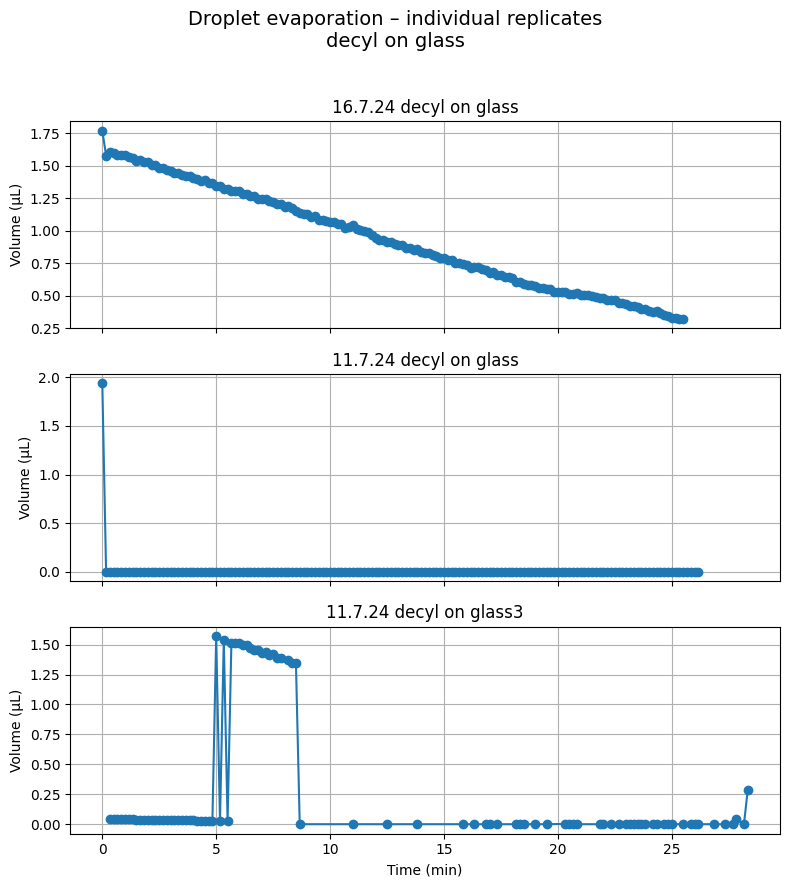

In [ ]:
# ======================================
#@title 6.1  Plot dv/dt per replicate (subplots)
# ======================================

import matplotlib.pyplot as plt

# --------------------------------------------------
# Safety checks
# --------------------------------------------------
if "dfs_by_run" not in globals():
    raise RuntimeError("❌ dfs_by_run not found. Run Stage 4–5 first.")

if "treatment_dir" not in globals():
    raise RuntimeError("❌ treatment_dir not defined.")

run_names = list(dfs_by_run.keys())
n_runs = len(run_names)

if n_runs == 0:
    raise RuntimeError("❌ No replicates found to plot.")

# --------------------------------------------------
# Create figure with subplots
# --------------------------------------------------
fig, axes = plt.subplots(
    n_runs, 1,
    figsize=(8, 3 * n_runs),
    sharex=True
)

# במקרה של רפליקה אחת
if n_runs == 1:
    axes = [axes]

# --------------------------------------------------
# Plot each replicate
# --------------------------------------------------
for ax, run_name in zip(axes, run_names):

    df = dfs_by_run[run_name]

    if df.empty:
        ax.set_title(f"{run_name} (empty)")
        continue

    time_min = df["time_s"] / 60.0

    ax.plot(
        time_min,
        df["volume_ul"],
        marker="o",
        linestyle="-"
    )

    ax.set_ylabel("Volume (µL)")
    ax.set_title(run_name)
    ax.grid(True)

axes[-1].set_xlabel("Time (min)")

fig.suptitle(
    f"Droplet evaporation – individual replicates\n{treatment_dir.name}",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


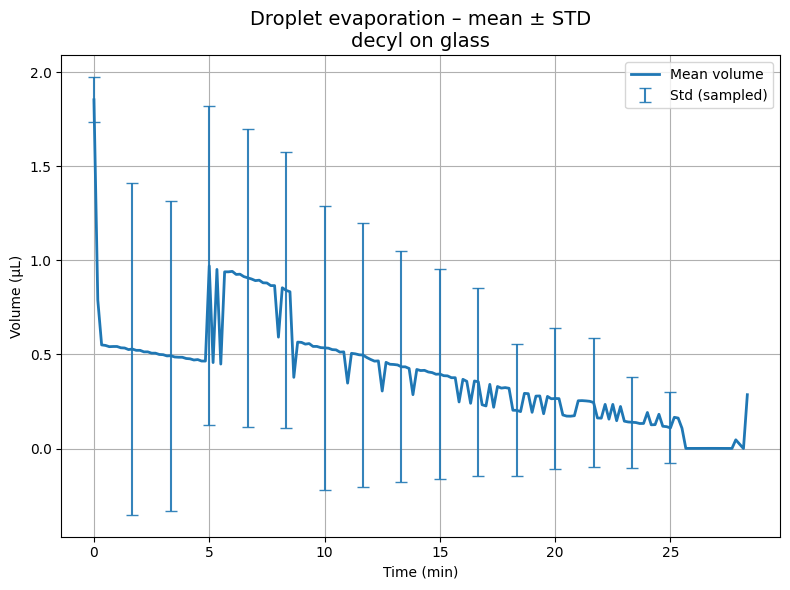

In [ ]:
# ======================================
#@title 6.2 Plot volume vs time mean with sparse std
# ======================================

import matplotlib.pyplot as plt
import pandas as pd

# --------------------------------------------------
# Load aggregated CSV
# --------------------------------------------------
agg_csv_path = treatment_dir / "aggregated" / "droplet_analysis_mean_std.csv"
agg_df = pd.read_csv(agg_csv_path)

# --------------------------------------------------
# Time conversion
# --------------------------------------------------
time_min = agg_df["time_s"] / 60.0

# --------------------------------------------------
# How sparse should the error bars be?
# --------------------------------------------------
STD_STEP = 10   # ← כל כמה נקודות להציג STD (שחקי עם 10 / 15 / 20)

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(8, 6))

# Mean curve (full resolution)
plt.plot(
    time_min,
    agg_df["volume_ul_mean"],
    color="C0",
    linewidth=2,
    label="Mean volume"
)

# Sparse error bars
plt.errorbar(
    time_min[::STD_STEP],
    agg_df["volume_ul_mean"][::STD_STEP],
    yerr=agg_df["volume_ul_std"][::STD_STEP],
    fmt="none",
    ecolor="C0",
    elinewidth=1.5,
    capsize=4,
    alpha=0.9,
    label="Std (sampled)"
)

plt.xlabel("Time (min)")
plt.ylabel("Volume (µL)")
plt.title(
    f"Droplet evaporation – mean ± STD\n{treatment_dir.name}",
    fontsize=14
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
